### Retrieval-Augmented Generation (RAG)

In [27]:
# Import required libraries for building a Retrieval-Augmented Generation (RAG) system
from langchain_groq import ChatGroq  
from langchain_community.document_loaders import PyPDFLoader  
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS

# Load environment variables from .env file
from dotenv import load_dotenv
_ = load_dotenv()

In [28]:
# Initialize the LLM and embedding model
# ChatGroq: Uses Groq API to access the GPT OSS 120B model for generating responses
llm = ChatGroq(model="openai/gpt-oss-120b")

# OllamaEmbeddings: Uses the Nomic embedding model to convert text into semantic vectors
# These embeddings enable similarity-based document retrieval
embedding = OllamaEmbeddings(model="nomic-embed-text:v1.5")

In [29]:
import os
# Function to load documents from a specified directory
def load_documents(data_dir):
    documents = []
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        # Load PDF files using PyPDFLoader
        if file.endswith(".pdf"):
            loader = PyPDFLoader(file_path)
            documents.extend(loader.load())
        # Optional: Support for DOCX files (commented out)
        # elif file.endswith(".docx"):
        #     loader = Docx2txtLoader(file_path)
        #     documents.extend(loader.load())
    return documents

In [30]:
docs = load_documents("data")
len(docs)

3

In [31]:
# Split documents into chunks for better retrieval and processing
# RecursiveCharacterTextSplitter breaks documents into manageable pieces while preserving context
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,      
    chunk_overlap=200   
)
chunks = splitter.split_documents(docs)

In [32]:
len(chunks)

15

In [33]:
chunks[0].page_content

'Generative AI and Its Applications Generative AI and Its Applications\nA Comprehensive Guide to Modern AI Systems\nA Comprehensive Guide to Modern AI Systems\n1. Introduction to Generative AI\n1. Introduction to Generative AI\nGenerative AI represents a paradigm shift in artificial intelligence, focusing on systems that can create new content rather than simply analyzing or classifying existing\ndata. These models leverage deep learning architectures, particularly transformer networks, to generate text, images, code, and other forms of content that closely\nmimic human-created outputs.\nAt the core of generative AI are large language models (LLMs) trained on vast amounts of data. These models learn patterns, relationships, and structures within the\ntraining data, enabling them to generate coherent and contextually relevant responses. The breakthrough came with attention mechanisms and transformer\narchitectures, which allow models to understand context across long sequences of text.'

In [34]:
# Create a FAISS vector database from document chunks
# FAISS (Facebook AI Similarity Search) enables fast similarity-based document retrieval
# Each chunk is converted to embeddings and indexed for efficient searching
vectorstore = FAISS.from_documents(chunks, embedding)

In [35]:
vectorstore

In [36]:
# Create a retriever from the vectorstore
# This retriever will find the k most similar documents for any given query
retriver = vectorstore.as_retriever(
    search_type="similarity",      
    search_kwargs={"k": 4}      
)

In [37]:
# Test the retriever with a sample query
r = retriver.invoke("RAG?")

In [38]:
# Display the content of the second retrieved document
# This shows how the retriever ranks and returns relevant documents
r[1].page_content

'2.2 RAG Workflow\n2.2 RAG Workflow\nThe RAG process follows a systematic workflow. When a user submits a query, the system first converts it into an embedding vector. This query embedding is then\nused to search the vector database for the most semantically similar document chunks. The retrieved documents are ranked by relevance, and the top-k results are\nselected as context.\nThe language model receives both the original query and the retrieved context as input, generating a response that synthesizes information from the provided\ndocuments. This approach significantly reduces hallucinations and allows the model to cite sources, improving trustworthiness and verifiability.\n2.3 Advanced RAG Techniques\n2.3 Advanced RAG Techniques\nModern RAG implementations employ sophisticated techniques to improve performance. Hybrid search combines dense vector search with traditional keyword-'

### Agent

In [39]:
# Import required libraries for building an agentic workflow
from langchain_core.tools import tool 
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage 
from langgraph.graph import StateGraph, START  
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated, TypedDict

In [40]:
# Define the RAG tool that the agent can use
@tool
def rag_tool(query):
    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    
    Args:
        query (str): The user's question or search term
        
    Returns:
        dict: Contains the query, retrieved context, and document metadata
    """
    # Retrieve the most relevant documents based on the query
    result = retriver.invoke(query)
    
    # Extract the text content and metadata from retrieved documents
    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]
    
    return {
        "query": query,
        "context": context,
        "metadata": metadata,
    }

In [41]:
# Bind the tools to the LLM so it can call them during generation
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [42]:
# Define the state structure for the chatbot workflow
# This TypedDict tracks the conversation history with automatic message aggregation
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [43]:
# Define the main chat node that processes messages and generates responses
def chat_node(state: ChatState):
    """
    Process the current messages and generate an LLM response.
    
    Args:
        state (ChatState): The current conversation state
        
    Returns:
        dict: Updated state with the new LLM response
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {
        "messages": [response]
    }

In [44]:
# Create a tool node that executes the RAG tool when the LLM requests it
tool_node = ToolNode(tools)

In [45]:
# Build the agentic workflow graph
graph = StateGraph(ChatState)

# Add nodes for different components of the workflow
graph.add_node("chat_node", chat_node)  
graph.add_node("tools", tool_node)      

# Set up the workflow flow
graph.add_edge(START, "chat_node")      
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")                 

# Compile the graph into a runnable chatbot
chatbot = graph.compile()

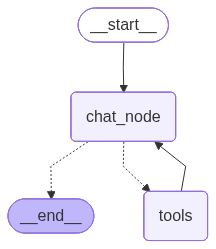

In [46]:
# Display a visual representation of the compiled chatbot workflow
chatbot

In [47]:
# Create a system message to guide the agent's behavior
system_msg = SystemMessage(
    content="You are a concise assistant. Always base answers on the provided PDF and clearly cite any document excerpts used."
)

# Execute the chatbot with a sample query
# The chatbot will:
# 1. Receive the system message and user query
# 2. Decide whether to use the RAG tool for document retrieval
# 3. Generate a response based on retrieved context
result = chatbot.invoke(
    {
        "messages": [
            system_msg,
            HumanMessage(content="Explain key components of RAG architecture?")
        ]
    }
)

In [48]:
# Extract and display the final response from the chatbot
r = result['messages'][-1].content

# Import and use IPython display utilities to render the response as formatted markdown
from IPython.display import Markdown, display
display(Markdown(r))

**Key components of a Retrieval‑Augmented Generation (RAG) system**

| Component | Role |
|-----------|------|
| **Document Corpus** | The source collection of texts, databases, or knowledge bases that contain the factual information to be retrieved. |
| **Embedding Model** | Converts each document (and the incoming query) into dense vector representations that capture semantic meaning. |
| **Vector Database** | Stores the document embeddings and enables fast similarity search (e.g., Pinecone, Weaviate, Chroma). |
| **Retrieval System** | Takes the query embedding, searches the vector store, and returns the most relevant document chunks. |
| **Language Model** | Receives the original query plus the retrieved context and generates a grounded response. |

These elements work together: the query is embedded, the vector DB is searched, the top‑k documents are passed to the LLM, and the LLM produces a response that is anchored in up‑to‑date information【0†L1-L9】【0†L10-L14】.